In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import tensorflow as tf
import time

In [2]:
# CONFIRM GPU ACCESS
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU (UUID: GPU-568f2418-97a2-eb4a-4350-001120466be8)


# Get Data

Before we can start building a model, we've got to download the PubMed 200k RCT dataset.

In a phenomenal act of kindness, the authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files on GitHub.

We can copy them to our local directory using git clone https://github.com/Franck-Dernoncourt/pubmed-rct.

In [3]:
!git clone  https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [4]:
!dir pubmed-rct

 Volume in drive C has no label.
 Volume Serial Number is 22DD-4F7C

 Directory of C:\Users\anmol\Desktop\TF\Udemy ZTM\10. Streamlit Project\pubmed-rct

19-01-2022  12:34    <DIR>          .
19-01-2022  12:34    <DIR>          ..
19-01-2022  12:34    <DIR>          PubMed_200k_RCT
19-01-2022  12:34    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
19-01-2022  12:34    <DIR>          PubMed_20k_RCT
19-01-2022  12:34    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
19-01-2022  12:34             2,403 README.md
               1 File(s)          2,403 bytes
               6 Dir(s)  210,081,992,704 bytes free


Checking the contents of the downloaded repository, you can see there are four folders.

Each contains a different version of the PubMed 200k RCT dataset.

Looking at the README file from the GitHub page, we get the following information:

- PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
- PubMed_200k_RCT is the same as PubMed_200k_RCT_numbers_replaced_with_at_sign, except that in the latter all numbers had been replaced by @. (same for PubMed_20k_RCT vs. PubMed_20k_RCT_numbers_replaced_with_at_sign).
- Since Github file size limit is 100 MiB, we had to compress PubMed_200k_RCT\train.7z and PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip. To uncompress train.7z, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.

To begin with, the dataset we're going to be focused on is PubMed_20k_RCT_numbers_replaced_with_at_sign.

Why this one?

Rather than working with the whole 200k dataset, we'll keep our experiments quick by starting with a smaller subset. We could've chosen the dataset with numbers instead of having them replaced with @ but we didn't.

Let's check the file contents.

In [5]:
# check what files are in the PUB_MED_20k RCT
os.listdir(r"C:\Users\anmol\Desktop\TF\Udemy ZTM\10. Streamlit Project\pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign")

['dev.txt', 'test.txt', 'train.txt']

In [6]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [7]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Pre-process Data
Let's write a function to read in all the lines of a target text file

In [8]:
def get_lines(filename):
    """
    Reads a filename and returns the lines of text as a list
    Args: filename containing target filepath
    Returns: A list of strings with one string per line from the target filename
    """
    with open(filename, "r") as f:
        return f.readlines()

In [9]:
# Lets read in the training lines
train_lines  = get_lines(data_dir+"train.txt") # read the lines in the training file
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines)

210040

Reading the lines from the training text file results in a list of strings containing different abstract samples, the sentences in a sample along with the role the sentence plays in the abstract.

The role of each sentence is prefixed at the start of each line separated by a tab (\t) and each sentence finishes with a new line (\n).

Different abstracts are separated by abstract ID's (lines beginning with ###) and newlines (\n).

Knowing this, it looks like we've got a couple of steps to do to get our samples ready to pass as training data to our future machine learning model.

Let's write a function to perform the following steps:

- Take a target file of abstract samples.
- Read the lines in the target file.
- For each line in the target file:
        - If the line begins with ### mark it as an abstract ID and the beginning of a new abstract.
            - Keep count of the number of lines in a sample.
        - If the line begins with \n mark it as the end of an abstract sample.
            - Keep count of the total lines in a sample.
        - Record the text before the \t as the label of the line.
        - Record the text after the \t as the text of the line.
 - Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
        - "line_number" - the position of the line in the abstract (e.g. 3).
        - "target" - the role of the line in the abstract (e.g. OBJECTIVE).
        - "text" - the text of the line in the abstract.
        - "total_lines" - the total lines in an abstract sample (e.g. 14).
 - Abstract ID's and newlines should be omitted from the returned preprocessed data.


In [11]:
def preprocess_text_with_line_numbers(filename):
    """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
    input_lines = get_lines(filename) # get all the filenames
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts
    
    # Loop through each line in target file
    for line in input_lines:
        if line.startswith("###"): # check to see if line is a line ID
            abstract_id = line
            abstract_lines = "" # reset abstract string if the line is an ID line
        elif line.isspace(): # check to see if line is a  new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
            
            # iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create empty dict to store data from each line
                target_text_split = abstract_line.split("\t") # split target label from text
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list
    
        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
                abstract_lines += line
  
    return abstract_samples

In [12]:
# Get data from file and preprocess it
%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

Wall time: 0 ns


(180040, 30212, 30135)

In [13]:
# check the first abstract of training samples
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [14]:
# Convert our training, val and test samples into a DataFrame
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [16]:
# Distribution of labels in training data
print(train_df["target"].value_counts())
print('\n')
print(train_df["target"].value_counts(normalize=True))

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64


METHODS        0.329666
RESULTS        0.321890
CONCLUSIONS    0.150900
BACKGROUND     0.120679
OBJECTIVE      0.076866
Name: target, dtype: float64


<AxesSubplot:ylabel='Frequency'>

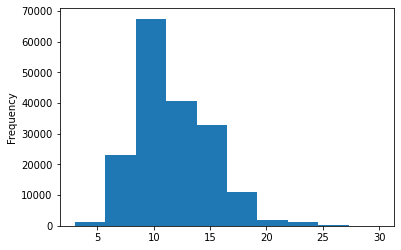

In [17]:
# lets check the lenght of different lines
train_df['total_lines'].plot(kind="hist")

Okay, looks like most of the abstracts are around 7 to 15 sentences in length.

It's good to check these things out to make sure when we do train a model or test it on unseen samples, our results aren't outlandish

#### Get list of sentences

When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

We can get these easily from our DataFrames by calling the tolist() method on our "text" columns.

In [18]:
# Convert Abstract text lines into Lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
# View the first 1o lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

#### Turn Target labels into Numeric Labels
We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we'll use Scikit-Learn's OneHotEncoder and LabelEncoder classes.

In [20]:
# One hot encoded labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))

# One hot encode val_df and test_df
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#### Label Encoded Labels

In [21]:
# Extract Labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check the labels
train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

Now we've trained an instance of LabelEncoder, we can get the class names and number of classes using the classes_ attribute.

In [22]:
# Get the class names and Number of Classes from labelEncoder Instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model 0: Baseline Model (Naive Bayes with TF-IDF encoder)

Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by Scikit-Learn's machine learning map.

To build it, we'll create a Scikit-Learn Pipeline which uses the TfidfVectorizer class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the MultinomialNB aglorithm.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences,
           y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
                y = val_labels_encoded)

0.7218323844829869

In [25]:
# Make Predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [26]:
# Download helper Function Scripts
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-24 08:24:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.1'

     0K ..........                                            100% 1.20M=0.008s

2022-01-24 08:24:53 (1.20 MB/s) - 'helper_functions.py.1' saved [10246/10246]



In [27]:
# Import calculate results helper function
from helper_functions import calculate_results

In [28]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Preparing our data for deep sequence models
But before we start building deeper models, we've got to create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

In [29]:
# how long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

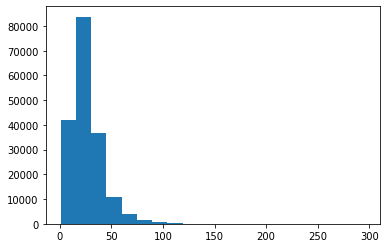

In [30]:
# Whats the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [31]:
# how long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# what is max sequence length in the training set
max(sent_lens)

296



Wonderful! It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off)

### Create Text Vectorizer
Now we've got a little more information about our texts, let's create a way to turn it into numbers.

To do so, we'll use the TextVectorization layer from TensorFlow.

We'll keep all the parameters default except for max_tokens (the number of unique words in our dataset) and output_sequence_length (our desired output length for each vectorized sentence).

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.

In [33]:
# how many words are in our vocab? 
max_tokens = 68000

In [34]:
# Create Text Vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in the vocabulary
                                   output_sequence_length = output_seq_len) # desired output length of vectorized sequences



Great! Looks like our text_vectorizer is ready, let's adapt it to the training data (let it read the training data and figure out what number should represent what word) and then test it out.


In [35]:
# Adapt Text Vectorizer to Training Sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test Out the Text Vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text: \n{target_sentence}")
print(f"\n Length of Text: {len(target_sentence.split())}")
print(f"\n Vectorized Text: {text_vectorizer([target_sentence])}")

Text: 
some @ patients ( @ colorectal resections and @ oesophagogastric resections ) were enrolled in the study ; @ patients were randomized to the restricted regimen and @ to the control ( liberal ) regimen .

 Length of Text: 36

 Vectorized Text: [[  584    12  1264  7993     3 12496  7993     9   230     5     2    17
     12     9    29     6     2  3026   576     3     6     2    35  6084
    576     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [37]:
# how many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most Common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common wods in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most Common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common wods in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


 We can also see the configuration of our Text_vectorizer by using the get_config method

In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create Custom Text Embedding
Our token_vectorization layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an embedding.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's Embedding layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our Embedding layer.

The input_dim parameter defines the size of our vocabulary. And the output_dim parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our text_vectorization layer as inputs and convert them to feature vectors of size output_dim.

Let's see it in action.

In [39]:
len(rct_20k_text_vocab)

64841

In [40]:
from tensorflow.keras import layers

# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), # length of the vocabulary
                              output_dim = 128, # Note: different embedding sizes result in drastically different number of parameters
                              # use masking to handle variable sequence lenghts (save space)
                              mask_zero = True,
                              name = "token_embedding")

In [41]:
# Show an example Embedding
print(f"Sentence before vectorization: \n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])

print(f"Sentence after vectorization (before embedding): \n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence After Embedding: \n {embedded_sentence}\n")
print(f"Embedded Sentence Shape: {embedded_sentence.shape}")

Sentence before vectorization: 
 some @ patients ( @ colorectal resections and @ oesophagogastric resections ) were enrolled in the study ; @ patients were randomized to the restricted regimen and @ to the control ( liberal ) regimen .

Sentence after vectorization (before embedding): 
 [[  584    12  1264  7993     3 12496  7993     9   230     5     2    17
     12     9    29     6     2  3026   576     3     6     2    35  6084
    576     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence After Embedding: 
 [[[-0.02232095 -0.0266737   0.03590759 ... -0.01200115 -0.01435008
   -0.02339635]
  [ 0.00711314 -0.02042933 -0.00904874 ... -0.04640546 -0.03075974
   -0.0451527 ]
  [-0.03445554  0.03833851  0.03085205 ... -0.00421218  0.0403224
   -0.04308284]
  ...
  [-0.03363948 -0.04586584  0.03195537 ... -0.04467024  0.00676165
   -0.00082598]
  [-

# Create Datasets (as fast as possible)

We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the tf.data API provides methods which enable faster data loading.

The main steps we'll want to use with our data is to turn it into a PrefetchDataset of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset we can use the methods batch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [42]:
# Turn our Data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset, valid_dataset, test_dataset

(<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>,
 <TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>,
 <TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>)

In [43]:
# Take the TensorSliced Datasets and Turn them into Prefetched Datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset, valid_dataset, test_dataset

(<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>,
 <PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>,
 <PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>)

# Model 1: Conv1D with token embeddings

Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

The main component we'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model we're going to build is a 1-dimensional Convolutional Neural Network.

We're also going to be following the standard machine learning workflow of:

   - Build model
   - Train model
   - Evaluate model (make predictions and compare to ground truth)


In [44]:
from tensorflow.keras import layers

# Create 1d conv model to process sequences
inputs = layers.Input(shape=(1,), dtype="string")
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding

x = layers.Conv1D(64,
                  kernel_size=5,
                  padding = "same",
                  activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the outputs of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

In [45]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [46]:
len(train_dataset), 5627*32

(5627, 180064)

Checking out the model summary, you'll notice the majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the output_dim parameter of the Embedding layer), the number of trainable parameters would increase dramatically.

It's time to fit our model to the training data but we're going to make a mindful change.

Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

In [47]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                             steps_per_epoch = int(0.1*len(train_dataset)),
                             epochs = 3,
                             validation_data = valid_dataset,
                             validation_steps = int(0.1* len(valid_dataset))) # only validate on 10% of data

Epoch 1/3
562/562 [==============================] - 18s 15ms/step - loss: 0.9054 - accuracy: 0.6432 - val_loss: 0.6876 - val_accuracy: 0.7387
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.6628 - accuracy: 0.7529 - val_loss: 0.6356 - val_accuracy: 0.7689
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6226 - accuracy: 0.7697 - val_loss: 0.5992 - val_accuracy: 0.7846


In [48]:
# Evaluate the model performance on the whole dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.6028 - accuracy: 0.7831


[0.6028105020523071, 0.7830663323402405]

In [49]:
# Make Predictions (class probabilities for each line)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[3.91332597e-01, 1.67458832e-01, 1.22985855e-01, 2.82708734e-01,
         3.55139412e-02],
        [4.82417881e-01, 2.37662911e-01, 1.17992442e-02, 2.62585610e-01,
         5.53439651e-03],
        [1.61472842e-01, 7.19813909e-03, 1.99214392e-03, 8.29298794e-01,
         3.80505626e-05],
        ...,
        [2.00022896e-06, 6.30265102e-04, 6.36468583e-04, 1.88513343e-06,
         9.98729408e-01],
        [6.09496161e-02, 4.89033848e-01, 9.26000774e-02, 6.45974800e-02,
         2.92818993e-01],
        [1.84666127e-01, 6.17708981e-01, 4.87222485e-02, 5.53984754e-02,
         9.35041532e-02]], dtype=float32),
 (30212, 5))

In [50]:
# Convert the prediction probabilities to Classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [51]:
# calculate model_1_results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model_1_preds)
model_1_results

{'accuracy': 78.30663312591022,
 'precision': 0.7794432269574944,
 'recall': 0.7830663312591023,
 'f1': 0.7804796827257772}

In [52]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 2: Tensorflow Hub Pretrained Feature Extractor

Training our own embeddings took a little while to run, slowing our experiments down.

Since we're moving towards replicating the model architecture in Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it mentions they used a pretrained GloVe embedding as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.

We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save using pretrained GloVe embeddings as an extension.

The model structure will look like:

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)

You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, feature extraction transfer learning. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

In [53]:
USE_model_path = os.getcwd()
USE_model_path

'C:\\Users\\anmol\\Desktop\\TF\\Udemy ZTM\\10. Streamlit Project'

In [54]:
# Download Pretrained Tensorflow Hub USE
import tensorflow_hub as hub

os.environ['TFHUB_CACHE_DIR'] = USE_model_path # we need this step in local environ or it will throw and OSError
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                         trainable=False,
                                         name="universal_sentence_encoder")

Now our pretrained USE is downloaded and instantiated as a hub.KerasLayer instance, let's test it out on a random sentence.

In [55]:
# Test out our Embedding layer on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random Training Sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])

print(f"Sentence after Embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of Sentence Embedding:\n{len(use_embedded_sentence[0])}")

Random Training Sentence:
the effect of discrimination on health behaviors remains untested .

Sentence after Embedding:
[-0.03081647  0.04093629  0.00340908 -0.02042623 -0.01749281  0.02952602
 -0.02629447 -0.03338951  0.00345713  0.01958073  0.08750419 -0.00139212
  0.07354607 -0.00813268 -0.01694399 -0.06834848 -0.09154215  0.0418715
  0.01930941  0.0022494   0.00328021  0.06613974 -0.01472412 -0.06775061
  0.05249674  0.00687308 -0.01867011  0.06636602  0.02688682  0.07246067] (truncated output)...

Length of Sentence Embedding:
512


Nice! As we mentioned before the pretrained USE module from TensorFlow Hub takes care of tokenizing our text for us and outputs a 512 dimensional embedding vector.

Let's put together and compile a model using our tf_hub_embedding_layer.

### Building and Fitting an NLP feature extraction Model from Tensorflow Hub

In [56]:
# Define feature extractor model using TF Hub Layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding layer
# we can add more layers if we wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs =inputs,
                        outputs = outputs)

# compile the model
model_2.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

In [57]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________




Checking the summary of our model we can see there's a large number of total parameters, however, the majority of these are non-trainable. This is because we set training=False when we instatiated our USE feature extractor layer.

So when we train our model, only the top two output layers will be trained.


In [58]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 17s 28ms/step - loss: 0.9117 - accuracy: 0.6532 - val_loss: 0.7958 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 15s 27ms/step - loss: 0.7676 - accuracy: 0.7018 - val_loss: 0.7530 - val_accuracy: 0.7074
Epoch 3/3
562/562 [==============================] - 16s 28ms/step - loss: 0.7497 - accuracy: 0.7127 - val_loss: 0.7344 - val_accuracy: 0.7124


In [59]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.7380 - accuracy: 0.7143


[0.737966001033783, 0.7142525911331177]

In [60]:
# Make Predictions with Feature Extraction Model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.43513453, 0.3824327 , 0.00227317, 0.17392766, 0.00623191],
       [0.33388597, 0.5168275 , 0.00287113, 0.14396575, 0.00244961],
       [0.22936177, 0.11943837, 0.01893151, 0.5961641 , 0.03610417],
       ...,
       [0.0018522 , 0.00475285, 0.0524514 , 0.00096403, 0.9399795 ],
       [0.00388621, 0.04444254, 0.188335  , 0.00154241, 0.76179385],
       [0.17746787, 0.23288561, 0.52043414, 0.00906749, 0.06014491]],
      dtype=float32)

In [61]:
# convert prediction probabilities to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [62]:
# Calculate results from TF Hub pretrained embeddings results on Val set
model_2_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model_2_preds)
model_2_results

{'accuracy': 71.42526148550245,
 'precision': 0.7141725634529341,
 'recall': 0.7142526148550244,
 'f1': 0.7112768558436364}

In [63]:
print(baseline_results)
print('\n')
print(model_1_results)

{'accuracy': 72.1832384482987, 'precision': 0.7186466952323352, 'recall': 0.7218323844829869, 'f1': 0.6989250353450294}


{'accuracy': 78.30663312591022, 'precision': 0.7794432269574944, 'recall': 0.7830663312591023, 'f1': 0.7804796827257772}


# Model 3: Conv1D with Character Embeddings

### Creating a CHARACTER-LEVEL TOKENIZER

The Neural Networks for Joint Sentence Classification in Medical Paper Abstracts paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, how about we build one using a character embedding?

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a token embedding is created on sequences split into tokens.

Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the TextVectorization class and then passing those vectorized sequences through an Embedding layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

In [64]:
target_sentence

'some @ patients ( @ colorectal resections and @ oesophagogastric resections ) were enrolled in the study ; @ patients were randomized to the restricted regimen and @ to the control ( liberal ) regimen .'

In [65]:
# make a fucntion to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# test splitting non-character-level sequence into character
split_chars(target_sentence)

's o m e   @   p a t i e n t s   (   @   c o l o r e c t a l   r e s e c t i o n s   a n d   @   o e s o p h a g o g a s t r i c   r e s e c t i o n s   )   w e r e   e n r o l l e d   i n   t h e   s t u d y   ;   @   p a t i e n t s   w e r e   r a n d o m i z e d   t o   t h e   r e s t r i c t e d   r e g i m e n   a n d   @   t o   t h e   c o n t r o l   (   l i b e r a l   )   r e g i m e n   .'

In [66]:
# list(train_sentences[0])
# " ".join(list(train_sentences[0]))

In [67]:
# Split sequence level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [68]:
# Whats the average character length??
char_lens = [len(sentence) for sentence in train_sentences]

mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

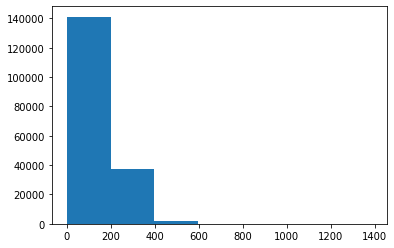

In [69]:
# Check the distribution of our sequences at a character-level
plt.hist(char_lens, bins=7)

In [70]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

Wonderful, now we know the sequence length which covers 95% of sequences, we'll use that in our TextVectorization layer as the output_sequence_length parameter.

We'll set **max_tokens (the total number of different characters in our sequences) to 28**, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [71]:
# Get all keyboard characters
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [72]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocabulary, '[UNK]')

char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                   output_sequence_length = output_seq_char_len,
                                   # standardization # set standardization to None we want to leave the punctuations intact  
                                   name = "char_vectorizer")

In [73]:
# Adapt Character vectorizer to Training characters
char_vectorizer.adapt(train_chars)

Now we've adapted our char_vectorizer to our character-level sequences, let's check out some characteristics about it using the get_vocabulary() method.

In [74]:
# Check character Vocab Stats
char_vocab = char_vectorizer.get_vocabulary()

print(f"The number of different characters in character vocab: {len(char_vocab)}")
print(f"The 5 most common characters: {char_vocab[:5]}")
print(f"The 5 least common characters: {char_vocab[-5:]}")

The number of different characters in character vocab: 28
The 5 most common characters: ['', '[UNK]', 'e', 't', 'i']
The 5 least common characters: ['k', 'x', 'z', 'q', 'j']


we should not that the number of different characters in the vocab is only 28. This is due to the fact that we did not define the **standardize paramter in out text vectorizer** and it took the **predefined value of that parameter as "lower_and_strip_punctuation"**. If we defined standardiztion to None, we would get 57 different characters in the character vocabulary.

In [75]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text: \n {random_train_chars}")
print(f"\n Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\n Vectorized chars: \n {vectorized_chars}")
print(f"\n Length of Vectorized chars: {len(vectorized_chars[0])}")

Charified text: 
 k n o w l e d g e   o f   t h e   h e a l t h   r i s k s   r e s u l t i n g   f r o m   t h e   l i f e s t y l e   c a n   b e   a   d e c i s i v e   f a c t o r   f o r   t h e   i m p l e m e n t a t i o n   o f   h e a l t h   b e h a v i o u r   .

 Length of random_train_chars: 108

 Vectorized chars: 
 [[23  6  7 20 12  2 10 18  2  7 17  3 13  2 13  2  5 12  3 13  8  4  9 23
   9  8  2  9 16 12  3  4  6 18 17  8  7 15  3 13  2 12  4 17  2  9  3 19
  12  2 11  5  6 22  2  5 10  2 11  4  9  4 21  2 17  5 11  3  7  8 17  7
   8  3 13  2  4 15 14 12  2 15  2  6  3  5  3  4  7  6  7 17 13  2  5 12
   3 13 22  2 13  5 21  4  7 16  8  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  

### Creating Character level Embedding

We've got a way to vectorize our character-level sequences, now's time to create a character-level embedding.

Just like our custom token embedding, we can do so using the tensorflow.keras.layers.Embedding class.

Our character-level embedding layer requires an input dimension and output dimension.

The input dimension (input_dim) will be equal to the number of different characters in our char_vocab (28). And since we're following the structure of the model in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, the output dimension of the character embedding (output_dim) will be 25.

In [76]:
# create char level embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab), # number of different characters
                             output_dim = 25, # this is the size of the char embedding in the paper
                             mask_zero = False,
                             name = 'char_level_embedding')

In [77]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
k n o w l e d g e   o f   t h e   h e a l t h   r i s k s   r e s u l t i n g   f r o m   t h e   l i f e s t y l e   c a n   b e   a   d e c i s i v e   f a c t o r   f o r   t h e   i m p l e m e n t a t i o n   o f   h e a l t h   b e h a v i o u r   .

Embedded chars (after vectorization and embedding):
[[[-0.02972445 -0.04431931 -0.04921539 ...  0.00472132 -0.02338445
    0.03214229]
  [-0.0236127   0.01857271  0.04343564 ...  0.0259049  -0.00787624
    0.02205438]
  [ 0.02320838  0.03124538  0.02752415 ...  0.03286593 -0.01313437
    0.00490538]
  ...
  [-0.0065372   0.0125866   0.0378632  ... -0.03569172 -0.00947137
    0.02411656]
  [-0.0065372   0.0125866   0.0378632  ... -0.03569172 -0.00947137
    0.02411656]
  [-0.0065372   0.0125866   0.0378632  ... -0.03569172 -0.00947137
    0.02411656]]]

Character embedding shape: (1, 290, 25)


The (1,290,25) represents: 1 means we are passing 1 sequence. 290 means the each line get padded to 290 characters and 25 means each of those 290 characters get turned into a feature vector of dimension 25.

Wonderful! Each of the characters in our sequences gets turned into a 25 dimension embedding.

### Building Conv1D model to fit on the character level embedding

Now we've got a way to turn our character-level sequences into numbers (char_vectorizer) as well as numerically represent them as an embedding (char_embed) let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (model_1) except it'll take character-level sequences as input instead of token-level sequences.

Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)

In [78]:
# Make Conv1d on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)

x = layers.Conv1D(64,
                  kernel_size=5,
                  padding="same",
                  activation="relu")(char_embeddings)

x = layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs = inputs,
                        outputs = outputs,
                        name = "model_3_conv1D_char_embeddins")

# compile the model
model_3.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

In [79]:
# check the model summary
model_3.summary()

Model: "model_3_conv1D_char_embeddins"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_level_embedding (Embed  (None, 290, 25)          700       
 ding)                                                           
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                     

#### Create Char Datasets
we need to do this so that the data loads faster into the model

In [80]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,
                                                         train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


# Create chat level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Fit the Model on Chars only

In [81]:
model_3_history = model_3.fit(train_char_dataset,
                             steps_per_epoch = int(0.1*len(train_char_dataset)),
                             epochs = 3,
                             validation_data = val_char_dataset,
                             validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 9ms/step - loss: 1.2786 - accuracy: 0.4770 - val_loss: 1.0412 - val_accuracy: 0.5924
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0067 - accuracy: 0.5993 - val_loss: 0.9395 - val_accuracy: 0.6316
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9272 - accuracy: 0.6381 - val_loss: 0.8668 - val_accuracy: 0.6695


In [82]:
# Evaluate the model on the complete dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.8860 - accuracy: 0.6561


[0.8860025405883789, 0.6560969352722168]

In [83]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.19197772, 0.3825256 , 0.06708797, 0.29145238, 0.06695638],
       [0.23854983, 0.28545627, 0.03962074, 0.34234232, 0.09403089],
       [0.14074183, 0.42982948, 0.0965666 , 0.24047549, 0.09238666],
       ...,
       [0.01318915, 0.04437422, 0.38261807, 0.04267447, 0.5171441 ],
       [0.06965525, 0.24397565, 0.2310723 , 0.05889378, 0.39640304],
       [0.5245124 , 0.26303473, 0.08586539, 0.11167011, 0.01491736]],
      dtype=float32)

In [84]:
# convert the prediction probabilities to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 1, ..., 4, 4, 0], dtype=int64)>

In [85]:
# calculate Conv1d char model results
model_3_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model_3_preds)
model_3_results

{'accuracy': 65.60969151330596,
 'precision': 0.6504062939616597,
 'recall': 0.6560969151330597,
 'f1': 0.6479062786956361}

# Model 4:  Combining pretrained token embeddings + character embeddings (hybrid embedding layer)
This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

   1. Create a token-level model (similar to model_1)
   2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
   3. Combine (using layers.Concatenate) the outputs of 1 and 2
   4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
   5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output


In [86]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs) # tf_hub layer from model 1
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                            outputs = token_outputs)

# 2. setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors) # same from model 3
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                           outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output,
                                                                   char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct Model with Char and Token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                        outputs = output_layer,
                        name = "model_4_token_and_char_embeddings")

In [87]:
# Get the summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

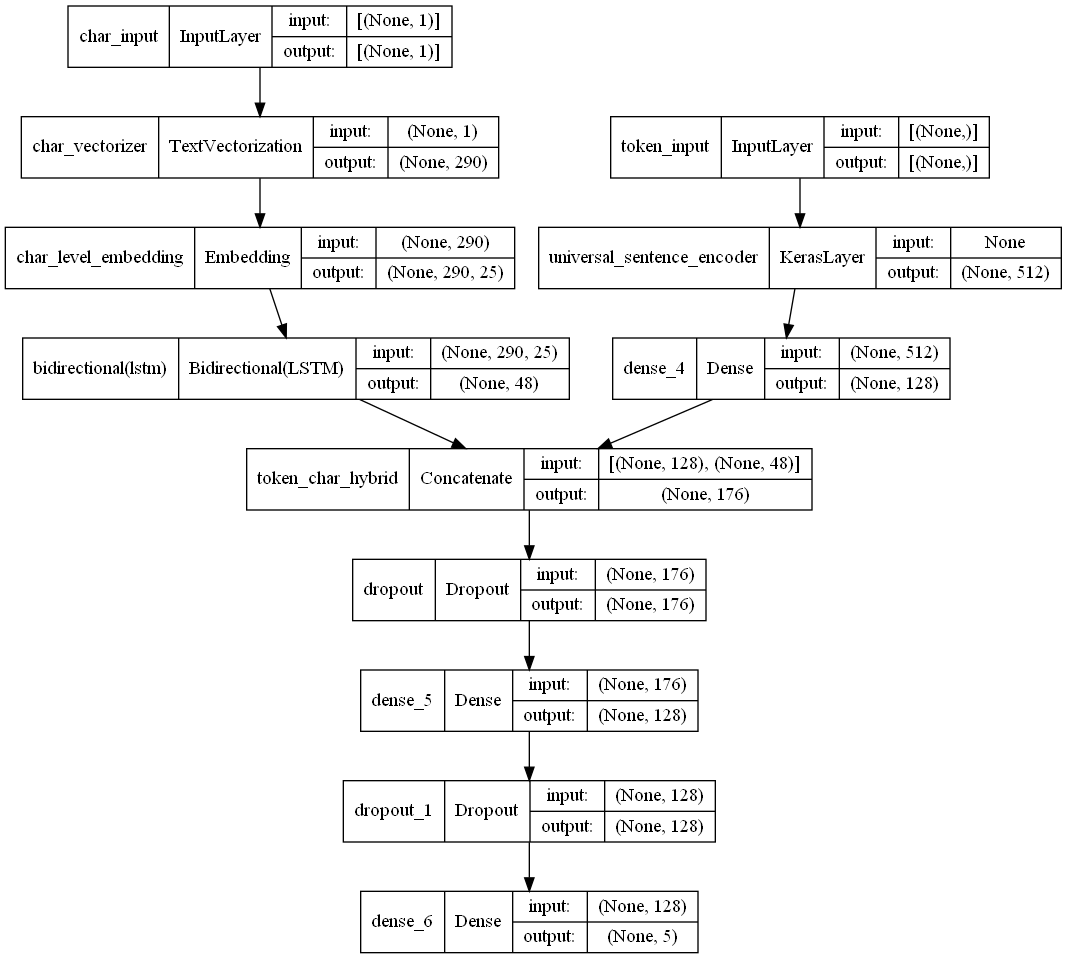

In [88]:
# Plot model_4 structure
# from keras.utils import plot_model (this throws an error)

from keras.utils.vis_utils import plot_model
plot_model(model_4, show_shapes=True)

In [89]:
# Compile token char model
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

And again, to keep our experiments fast, we'll fit our token-character-hybrid model on 10% of training and validate on 10% of validation batches. However, the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a tf.data.Dataset with a tuple as it's first input, for example:

   - ((token_data, char_data), (label))


### Combine token and character data into tf.data.Dataset for faster data loading

In [90]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data (takes in both token level and char level data)
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [91]:
# Repeat the above steps for our Validation Steps
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data (takes in both token level and char level data)
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Repeat the steps for test data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars)) # make data (takes in both token level and char level data)
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # make labels
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels)) # combine data and labels
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [92]:
# Check out the training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

**Note:** Note that when we built the model, we set input as (token, chars), so when we build the prefetch dataset, we need to keep in mind the same order. If we didn't do this, the model may send the wrong inputs. 

### Fitting the model

In [93]:
model_4_history = model_4.fit(train_char_token_dataset,
                             steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                             validation_data = val_char_token_dataset,
                            validation_steps = int(0.1* len(val_char_token_dataset)),
                             epochs = 3)

Epoch 1/3
562/562 [==============================] - 33s 51ms/step - loss: 0.9868 - accuracy: 0.6034 - val_loss: 0.7795 - val_accuracy: 0.6958
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.7992 - accuracy: 0.6904 - val_loss: 0.7212 - val_accuracy: 0.7251
Epoch 3/3
562/562 [==============================] - 27s 48ms/step - loss: 0.7790 - accuracy: 0.7019 - val_loss: 0.6981 - val_accuracy: 0.7380


In [94]:
# Evaluate on the whole dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 31s 33ms/step - loss: 0.7011 - accuracy: 0.7316


[0.7011496424674988, 0.7316297888755798]

In [95]:
# Make Predictions on the validation dataset
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.24051285e-01, 3.55222642e-01, 3.04356217e-03, 2.10138574e-01,
        7.54390657e-03],
       [3.01116824e-01, 5.38010955e-01, 3.23046139e-03, 1.55291185e-01,
        2.35064211e-03],
       [2.91416287e-01, 1.13154754e-01, 3.50816250e-02, 5.25662363e-01,
        3.46849971e-02],
       ...,
       [4.21091856e-04, 7.09103560e-03, 5.83449453e-02, 1.15098053e-04,
        9.34027851e-01],
       [5.86426770e-03, 4.21627499e-02, 2.55146146e-01, 2.17191456e-03,
        6.94654882e-01],
       [3.32143873e-01, 2.00701877e-01, 3.74795556e-01, 4.35465798e-02,
        4.88120951e-02]], dtype=float32)

In [96]:
# turn predictions into classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [97]:
# calculate model results
model_4_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model_4_preds)
model_4_results

{'accuracy': 73.16298159671653,
 'precision': 0.7332005649175449,
 'recall': 0.7316298159671654,
 'f1': 0.7287917906557035}

# Model 5: Pretrained Token Embeddings + Character Embeddings + Positional Embeddings

It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled CONCLUSIONS at the beggining and sequences labelled OBJECTIVE at the end?

Abstracts typically come in a sequential order, such as:

    OBJECTIVE ...
    METHODS ...
    METHODS ...
    METHODS ...
    RESULTS ...
    CONCLUSIONS ...

Or

    BACKGROUND ...
    OBJECTIVE ...
    METHODS ...
    METHODS ...
    RESULTS ...
    RESULTS ...
    CONCLUSIONS ...
    CONCLUSIONS ...

Of course, we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,

    Sentence 1 of 10 ...
    Sentence 2 of 10 ...
    Sentence 3 of 10 ...
    Sentence 4 of 10 ...
    ...

You might've noticed this when we created our preprocess_text_with_line_numbers() function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the "line_number" and "total_lines" columns of our DataFrames.

The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to our model as a positional embedding. In other words, the positional embedding is where the sentence appears in an abstract.

Since abstracts typically have a sequential order about them (for example, background, objective, methods, results, conclusion), it makes sense to add the line number of where a particular sentence occurs to our model. The beautiful thing is, these features will be available at test time (we can just count the number of sentences in an abstract and the number of each one).

Meaning, if we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and the track the position of each individual line and pass it to our model.

### Create Positional Embedding

Since our "line_number" and "total_line" columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with "line_number"=5 is five times greater than a line with "line_number"=1, we'll use one-hot-encoding to encode our "line_number" and "total_lines" features.

To do this, we can use the tf.one_hot utility.

tf.one_hot returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the depth parameter determines the dimension of the returned tensor.

To figure out what we should set the depth parameter to, let's investigate the distribution of the "line_number" column.

In [99]:
# how many different line numbers are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

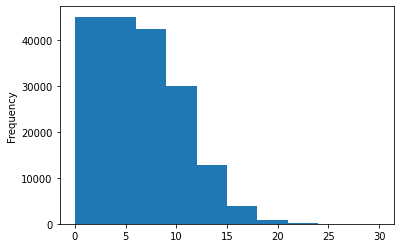

In [100]:
# check line_number distribution
train_df.line_number.plot.hist()

In [104]:
# Use Tensorflow to create One-Hot-Encoded tensors of our line_number column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)

val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Setting the depth parameter of tf.one_hot to 15 means any sample with a "line_number" value of over 15 gets set to a tensor of all 0's, where as any sample with a "line_number" of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the "line_number" value.

In [105]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

We can do the same as we've done for our "line_number" column witht he "total_lines" column. First, let's find an appropriate value for the depth parameter of tf.one_hot

In [106]:
# how many different numbers of lines are there
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<AxesSubplot:ylabel='Frequency'>

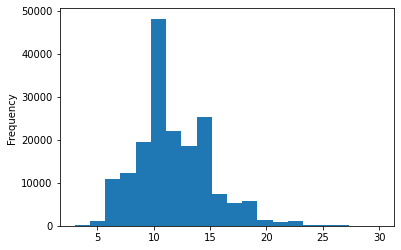

In [109]:
# check the distribution for total_lines
train_df.total_lines.plot.hist(bins = 20)



Looking at the distribution of our "total_lines" column, a value of 20 looks like it covers the majority of samples.

We can confirm this with np.percentile().


In [111]:
# check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [113]:
# use tensoflow to one hot encode tensors of our "total_lines" features
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building our TRIBRID Embedding Model

   1. Create a token-level model (similar to model_1)
   2.  Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
   3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
   4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
   5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
   6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
   7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
   8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model


In [122]:
# 1.Token Inputs 
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                            outputs = token_outputs)

# 2.Char Inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                           outputs = char_bi_lstm)

# 3.Line Numbers Model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input" )
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                  outputs = x)

# 4.Total Lines Input
total_lines_inputs = layers.Input(shape=(20,), dtype = tf.float32, name ="total_lines_model")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                  outputs = y)

# 5. Combine Token and Char Embeddings into a Hybrid Embeddings
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embeddings")([token_model.output,
                                                                              char_model.output])

# pass through dropout layer
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined char-token embeddings
tribrid_embeddings = layers.Concatenate(name = "char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                  total_lines_model.input,
                                  token_model.input,
                                  char_model.input],
                        outputs = output_layer,
                        name="tribrid_embedding_model")


In [123]:
# Get the Model Summary()
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

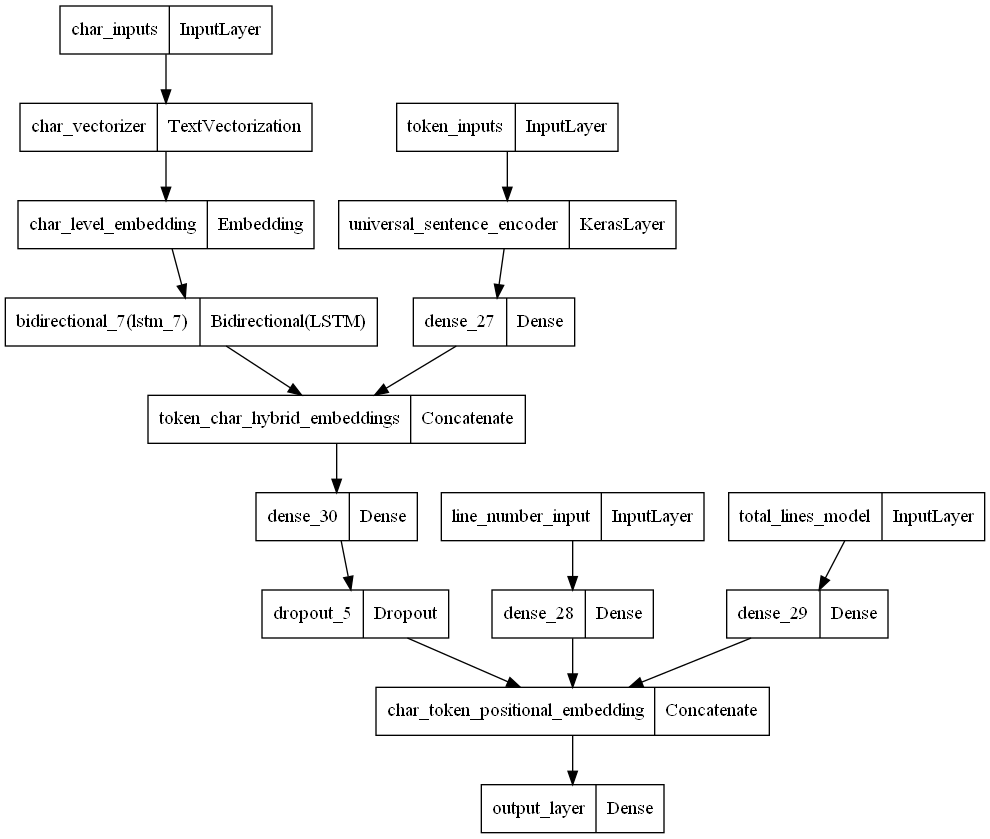

In [124]:
# Plot model 5 structure 
from keras.utils.vis_utils import plot_model
plot_model(model_5)

In [125]:
# Compile token, char, positional embedding layer
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),  # label smoothing helps to prevent overfitting
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

This time, we're going to introduce a new parameter to our loss function called label_smoothing. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

   - **[0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).**

It's predictions will get smoothed to be something like:

   - **[0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization.**


In [126]:
# Check which layers in our tribrid model are trainable
for layer in model_5.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x00000266129BF4C8> True
<keras.engine.input_layer.InputLayer object at 0x000002661296B608> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x00000265FE2CFC88> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x000002640F5F3BC8> False
<keras.layers.embeddings.Embedding object at 0x00000265FBE24488> True
<keras.layers.core.dense.Dense object at 0x000002661296D188> True
<keras.layers.wrappers.Bidirectional object at 0x000002661294C808> True
<keras.layers.merge.Concatenate object at 0x0000026612B341C8> True
<keras.engine.input_layer.InputLayer object at 0x000002650E67EA88> True
<keras.engine.input_layer.InputLayer object at 0x0000026612AD8088> True
<keras.layers.core.dense.Dense object at 0x00000266120C4388> True
<keras.layers.core.dense.Dense object at 0x0000026611C079C8> True
<keras.layers.core.dense.Dense object at 0x0000026611F31C48> True
<keras.layers.core.dropout.Dropout object at 0x0000026612947808>

### Creating Tribrid Embedding Datasets and Fit Tribrid Model
Again, to keep our experiments swift, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:

   - Train line numbers one-hot tensor (train_line_numbers_one_hot)
   - Train total lines one-hot tensor (train_total_lines_one_hot)
   - Token-level sequences tensor (train_sentences)
   - Char-level sequences tensor (train_chars)

We can pass these as tuples to our tf.data.Dataset.from_tensor_slices() method to create appropriately shaped and batched PrefetchedDataset's.

In [130]:
train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [138]:
# create training and validation datasets (with all 4 kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                               train_total_lines_one_hot, # token lines
                                                               train_sentences, # train tokens
                                                               train_chars)) # train chars

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels)) # combine data and labels
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch data



# Validation Dataset
val_char_token_pos_data =  tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

In [137]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [139]:
# Fit the tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                             steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                             validation_data = val_char_token_pos_dataset,
                             validation_steps = int(0.1*len(val_char_token_pos_dataset)),
                             epochs=3)

Epoch 1/3
562/562 [==============================] - 35s 55ms/step - loss: 1.1013 - accuracy: 0.7182 - val_loss: 0.9852 - val_accuracy: 0.8032
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9697 - accuracy: 0.8137 - val_loss: 0.9526 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 29s 51ms/step - loss: 0.9519 - accuracy: 0.8210 - val_loss: 0.9415 - val_accuracy: 0.8314


In [140]:
# Evaluate on the whole dataset
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 32s 34ms/step - loss: 0.9391 - accuracy: 0.8320


[0.9390840530395508, 0.8319541811943054]

In [141]:
# model prediction probabilities
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 34s 34ms/step


array([[0.5033814 , 0.10739264, 0.01051892, 0.36275208, 0.01595501],
       [0.52075493, 0.10850684, 0.03623415, 0.32625353, 0.00825061],
       [0.2963758 , 0.10674297, 0.11874054, 0.41420838, 0.06393228],
       ...,
       [0.03164594, 0.0917406 , 0.03815237, 0.0287253 , 0.80973583],
       [0.0310246 , 0.29623485, 0.08585958, 0.02699936, 0.5598816 ],
       [0.27808875, 0.52322525, 0.09764165, 0.04057072, 0.06047353]],
      dtype=float32)

In [142]:
# turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [143]:
# calculate results of the model5
model_5_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model_5_preds)
model_5_results

{'accuracy': 83.19541903879252,
 'precision': 0.8314075818017067,
 'recall': 0.8319541903879253,
 'f1': 0.8308271726592735}

In [147]:
model_4_results, baseline_results

({'accuracy': 73.16298159671653,
  'precision': 0.7332005649175449,
  'recall': 0.7316298159671654,
  'f1': 0.7287917906557035},
 {'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294})

# Compare Model Results

In [149]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"baseline_model":baseline_results,
                                 "model_1custom_token_embed_conv1d": model_1_results,
                                  "model_2_pretrained_token_embed": model_2_results,
                                  "model_3_custom_char_embed_conv1d": model_3_results,
                                  "model_4_hybrid_char_token_embed": model_4_results,
                                  "model_5_tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline_model,72.183238,0.718647,0.721832,0.698925
model_1custom_token_embed_conv1d,78.306633,0.779443,0.783066,0.780480
model_2_pretrained_token_embed,71.425261,0.714173,0.714253,0.711277
model_3_custom_char_embed_conv1d,65.609692,0.650406,0.656097,0.647906
model_4_hybrid_char_token_embed,73.162982,0.733201,0.731630,0.728792
model_5_tribrid_pos_char_token_embed,83.195419,0.831408,0.831954,0.830827


In [150]:
# reduce accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

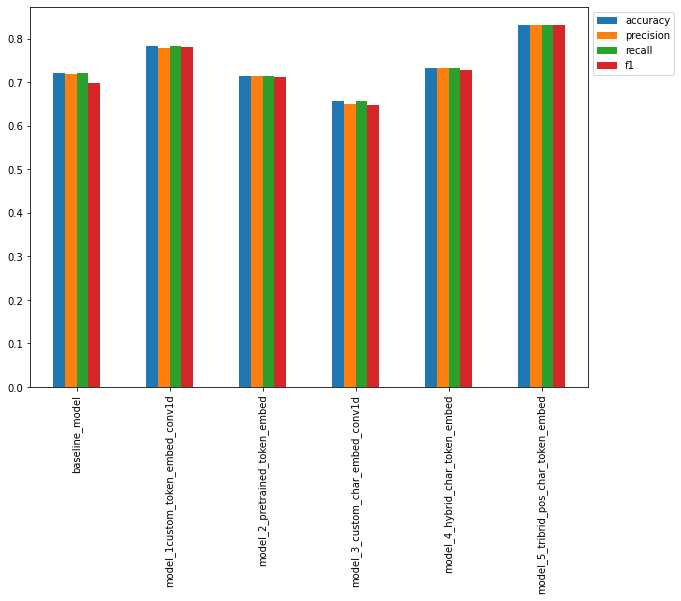

In [151]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

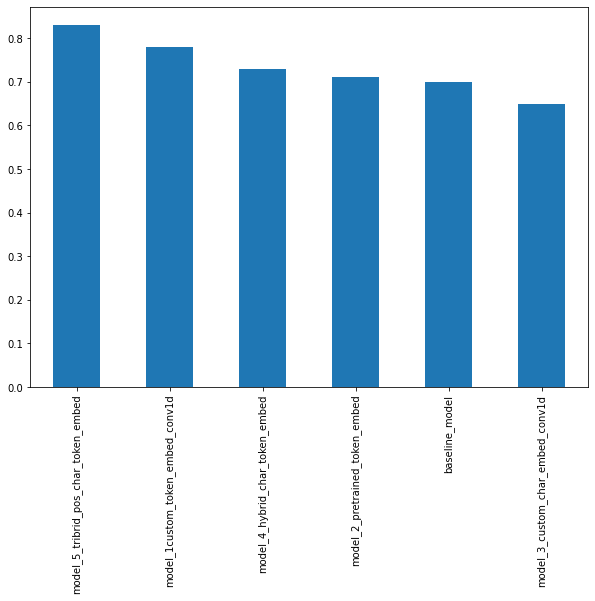

In [152]:
# sort model results by f1 scores
all_model_results.sort_values(by="f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

# Save and Load the Best Performing Model

In [153]:
# Save Best performimg model to SavedModel format
model_5.save("skimlit_tribrid_model") # model will be saved to path

INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


# Evaluate the Model on Test Dataset

In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(8).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

In [ ]:
model_5.evaluate(test_pos_char_token_dataset)

In [ ]:
# make predictions on the test dataset
test_pred_probs = model_5.predict(test_pos_char_token_dataset, verbose=1)

# test_preds = tf.argmax(test_pred_probs, axis=1)
# test_preds[:10]

In [ ]:
# Chech modelp